In [1]:
import os
import pandas

import numpy as np
import itertools

from multiprocessing import Pool

import scipy as sp
from scipy import optimize

import pickle as pkl

def exgauss_pdf(x, mu, sigma, nu):

    nu = 1./nu

    p1 = nu / 2. * np.exp((nu/2.)  * (2 * mu + nu * sigma**2. - 2. * x))


    p2 = sp.special.erfc((mu + nu * sigma**2 - x)/ (np.sqrt(2.) * sigma))

    return p1 * p2

def mixed_exgauss_likelihood(x, w, mu, sigma, nu):

    # Create indiviudal
    pdfs = w * exgauss_pdf(x[:, np.newaxis], mu, nu, sigma)

    ll = np.sum(np.log(np.sum(pdfs, 1)))

    if ((np.isnan(ll)) | (ll == np.inf)):
        return -np.inf


    return ll

def input_optimizer(pars, x, n_clusters):

    pars = np.array(pars)

    if np.sum(pars[:n_clusters-1]) > 1:
        return np.inf

    pars = np.insert(pars, n_clusters-1, 1 - np.sum(pars[:n_clusters-1]))

    if np.any(pars[:n_clusters] < 0.05):
        return np.inf

    w = pars[:n_clusters][np.newaxis, :]
    mu = pars[n_clusters:n_clusters*2][np.newaxis, :]
    nu = pars[n_clusters*2:n_clusters*3][np.newaxis, :]
    sigma = pars[n_clusters*3:n_clusters*4][np.newaxis, :]

    return -mixed_exgauss_likelihood(x, w, mu, sigma, nu)


def _fit(input_args, disp=False, popsize=100, **kwargs):

    sp.random.seed()

    x, n_clusters = input_args

    weight_bounds = [(1e-3, 1)] * (n_clusters - 1)
    mu_bounds = [(-1., 2.5)] * n_clusters
    nu_bounds = [(1e-3, 2.5)] * n_clusters
    sigma_bounds = [(1e-3, 2.5)] * n_clusters

    bounds = weight_bounds + mu_bounds + nu_bounds + sigma_bounds

    result = sp.optimize.differential_evolution(input_optimizer, bounds, (x, n_clusters), polish=True, disp=disp, maxiter=500, popsize=popsize, **kwargs)
    result = sp.optimize.minimize(input_optimizer, result.x, (x, n_clusters), method='SLSQP', bounds=bounds, **kwargs)

    return result

class SimpleExgaussMixture(object):


    def __init__(self, data, n_clusters):

        self.data = data
        self.n_clusters = n_clusters
        self.n_parameters = n_clusters * 4 - 1
        self.likelihood = -np.inf

        self.previous_likelihoods = []
        self.previous_pars = []


    def get_likelihood_data(self, data):
        
        return mixed_exgauss_likelihood(data, self.w, self.mu, self.sigma, self.nu)

    def _fit(self, **kwargs):
        return _fit((self.data, self.n_clusters), **kwargs)



    def fit(self, n_tries=1, **kwargs):
        for run in np.arange(n_tries):

            result = self._fit(**kwargs)
            self.previous_likelihoods.append(-result.fun)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])



    def fit_multiproc(self, n_tries=4, n_proc=4, disp=False):

        pool = Pool(n_proc)

#         print 'starting pool'
        results = pool.map(_fit, [(self.data, self.n_clusters)] * n_tries)
#         print 'ready'

#         print results



        pool.close()

        for result in results:
            self.previous_likelihoods.append(-result.fun)
            self.previous_pars.append(result.x)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])

    def plot_fit(self):
        # Create indiviudal pds

        t = np.linspace(0, self.data.max(), 100)
        pdfs = self.w * exgauss_pdf(t[:, np.newaxis], self.mu, self.nu, self.sigma)

        sns.distplot(self.data)
        plt.plot(t, pdfs, c='k', alpha=0.5)

        plt.plot(t, np.sum(pdfs, 1), c='k', lw=2)

# Get BIC/AIC

In [2]:
import glob
import re

In [3]:
fns = glob.glob('/home/gdholla1/data/post_mortem/ml_clusters_v2/*.pkl')
reg = re.compile('.*/(?P<subject_id>[0-9]+)_(?P<fwhm>[0-9]+\.[0-9]+)_(?P<stain>.*)_(?P<n_clusters>[0-9]+)\.pkl')

import pandas
fns = [fn for fn in fns if reg.match(fn)]
df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns])
df['fn'] = fns
df['fwhm'] = df['fwhm'].astype(float)
# df['bic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).bic)
# df['aic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).aic)
df['fit_object'] = df.fn.apply(lambda fn: pkl.load(open(fn)))

df['bic'] = df.fit_object.apply(lambda x: x.bic)
df['aic'] = df.fit_object.apply(lambda x: x.bic)

In [4]:
df.head()

,fwhm,n_clusters,stain,subject_id,fn,fit_object,bic,aic
0,1.0,2,GAD6567,15035,/home/gdholla1/data/post_mortem/ml_clusters_v2...,<__main__.SimpleExgaussMixture object at 0x77f...,-42479.862623,-42479.862623
1,1.0,4,SMI32,14069,/home/gdholla1/data/post_mortem/ml_clusters_v2...,<__main__.SimpleExgaussMixture object at 0x77f...,-8941.740250,-8941.740250
2,0.3,1,CALR,15035,/home/gdholla1/data/post_mortem/ml_clusters_v2...,<__main__.SimpleExgaussMixture object at 0x77f...,-31666.538307,-31666.538307
3,0.3,5,SYN,14051,/home/gdholla1/data/post_mortem/ml_clusters_v2...,<__main__.SimpleExgaussMixture object at 0x77f...,-15550.469083,-15550.469083
4,1.0,3,TRANSF,15055,/home/gdholla1/data/post_mortem/ml_clusters_v2...,<__main__.SimpleExgaussMixture object at 0x77f...,-7751.613598,-7751.613598


In [5]:
tmp = df[df.subject_id != '12104'].pivot_table(index=['subject_id','stain'], columns=['fwhm', 'n_clusters'])
tmp['bic_best_model'] = np.nanargmin(tmp['bic', 0.3].values, 1) + 1
tmp['aic_best_model'] = np.nanargmin(tmp['aic', 0.3].values, 1) + 1
tmp = tmp.reset_index()

In [6]:
tmp_bic = tmp

In [7]:
sns.set_context('poster')
sns.set_style('whitegrid')

In [8]:
bic = tmp.groupby(['stain', 'bic_best_model']).size()
aic = tmp.groupby(['stain', 'aic_best_model']).size()

In [9]:
bic = bic.to_frame('BIC').reset_index().rename(columns={'bic_best_model':'number of clusters'})
aic = aic.to_frame('AIC').reset_index().rename(columns={'aic_best_model':'number of clusters'})

In [10]:
bic.merge(aic).T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
stain,CALR,CALR,CALR,FER,FER,FER,GABRA3,GABRA3,GABRA3,GAD6567,...,SYN,SYN,TH,TH,TH,TRANSF,TRANSF,VGLUT1,VGLUT1,VGLUT1
number of clusters,2,3,4,2,3,4,2,3,5,1,...,3,4,2,3,4,2,3,2,3,4
BIC,2,3,2,5,1,1,1,5,1,4,...,3,3,5,1,1,4,3,3,2,2
AIC,2,3,2,5,1,1,1,5,1,4,...,3,3,5,1,1,4,3,3,2,2


# Get within-specimen cross validation

In [135]:
df = pandas.concat([pandas.read_pickle(fn) for fn in glob.glob('/home/gdholla1/data/post_mortem/ml_clusters_cross_validated/*_all.pandas')])

In [136]:
# df.pivot_table(index='subject_id', columns=['test', 'train', 'stain', 'n_clusters'], values='ll')
df['ll_norm'] = df.groupby(['stain', 'subject_id']).ll.transform(lambda x: x / x.mean())
df = df[df.subject_id != 12104]

In [137]:
df['out_of_sample'] = df.test != df.train


In [138]:
df['ll_norm'] = df.groupby(['stain', 'subject_id', 'fwhm']).ll.transform(lambda x: x / x.mean())

In [139]:
tmp = df.pivot_table(index=['out_of_sample', 'subject_id','stain'], columns=['fwhm', 'n_clusters'])
tmp['number of clusters'] = np.nanargmax(tmp['ll_norm', 0.3].values, 1) + 1
tmp = tmp.reset_index()
tmp = tmp[tmp.out_of_sample]

In [140]:
tmp_cv_within = tmp

In [141]:
cv_within = tmp.groupby(['stain', 'number of clusters']).size()
cv_within = cv_within.to_frame('cross-validated within-specimens').reset_index()

In [142]:
tmp = cv_within.merge(bic, how='outer').fillna(0)

In [143]:
tmp['cross-validation within-specimens'] = tmp['cross-validated within-specimens'].astype(int, inplace=True)
tmp['BIC'] = tmp['BIC'].astype(int, inplace=True)

In [144]:
tmp_bic.tail()

,subject_id,stain,bic_best_model,BIC/AIC
79,15055,SMI32,5,5
80,15055,SYN,3,3
81,15055,TH,2,2
82,15055,TRANSF,2,2
83,15055,VGLUT1,4,4


In [145]:
tmp_cv_within.tail()

out_of_sample subject_id   stain           aic                \
fwhm                                                  0.3                 
n_clusters                                              1             2   
163                 True      15055   SMI32   -745.987138 -1.940068e+03   
164                 True      15055     SYN  -6274.253893 -3.422785e+03   
165                 True      15055      TH -51454.999447 -2.799895e+06   
166                 True      15055  TRANSF -12378.439717 -1.233169e+04   
167                 True      15055  VGLUT1  -7807.134133 -7.944609e+03   

                                                                      \
fwhm                                                                   
n_clusters              3              4             5             6   
163          -2099.339826   -1810.547272  -1745.933084  -1669.161364   
164          -3550.761827   -3435.303082  -3506.750655  -3672.084389   
165        -243555.163874 -104286.722898 -82437.691185 -44571.509910   
166         -12282.234965  -12186.960632 -12195.981021 -12176.107605   
167          -7941.400893   -7917.997000  -7928.106192  -7905.636726   

                                ...           ll_norm                      \
fwhm                 1.0        ...               0.3                       
n_clusters             1        ...                 4         5         6   
163         -4319.157293        ...          0.469614  0.455169  0.437622   
164         -6664.049658        ...          0.303919  0.310886  0.326088   
165        -25762.330295        ...          0.187833  0.148506  0.080338   
166         -6687.684719        ...          0.966022  0.967368  0.966429   
167         -5499.215643        ...          0.987139  0.989388  0.987591   

                                                                        \
fwhm             1.0                                                     
n_clusters         1         2         3         4         5         6   
163         0.767200  0.675258  0.707485  0.627192  0.631038  0.636054   
164         0.546179  0.369468  0.366090  0.351528  0.356684  0.377585   
165         0.401395  3.747879  0.441465  0.441214  0.440857  0.441421   
166         0.905309  0.908967  0.932432  0.951993  0.943188  0.948048   
167         0.886773  1.006903  0.999021  1.008161  1.000749       NaN   

           number of clusters  
fwhm                           
n_clusters                     
163                         3  
164                         1  
165                         2  
166                         1  
167                         5  

[5 rows x 52 columns]

In [146]:
tmp_bic = tmp_bic[['subject_id', 'stain', 'bic_best_model']]
tmp_bic.columns = tmp_bic.columns.get_level_values(0)
tmp_bic['subject_id'] = tmp_bic['subject_id'].astype(int)
tmp_bic['BIC/AIC'] = tmp_bic['bic_best_model']


tmp_cv_within = tmp_cv_within[['subject_id', 'stain', 'number of clusters']]
tmp_cv_within.columns = tmp_cv_within.columns.get_level_values(0)
tmp_cv_within['cross validation within-specimens'] = tmp_cv_within['number of clusters']

In [147]:
tmp_swarm = tmp_bic.merge(tmp_cv_within, on=['subject_id', 'stain'], how='outer')

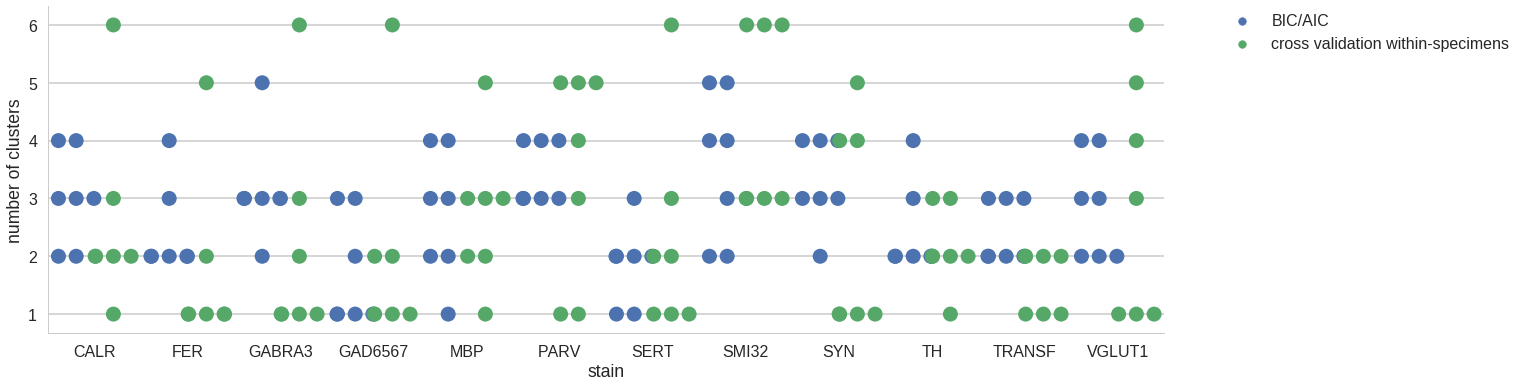

In [149]:
fac = sns.swarmplot('stain', 'number of clusters', 'variable', pandas.melt(tmp_swarm, id_vars=['subject_id', 'stain'], value_vars=['BIC/AIC', 'cross validation within-specimens'], value_name='number of clusters'), split=True, size=15)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.gcf().set_size_inches(20, 6)

# Get across-specimen cross validation

In [79]:
subject_ids = [14037, 15033, 15035, 14069, 13095, 14051, 15055]

stains = [u'CALR', u'FER', u'GABRA3', u'GAD6567', u'MBP', u'PARV', u'SERT', u'SMI32', u'SYN', u'TH', u'TRANSF', u'VGLUT1']
n_clusters = [1,2,3, 4, 5, 6]

fwhm = 0.3

In [80]:
def rescale_distribution_to(target, other):    
    def minimize_ks(pars):
        a, b = pars
        return sp.stats.ks_2samp(target, a + b * other)[0]
    
    result = sp.optimize.minimize(minimize_ks, ((0., 1.)), method='Nelder-Mead')
    
    a, b = result.x
    
    return a + b * other
    
    
    

In [81]:
results = []

for subject_id in subject_ids:
    for stain in stains:
        for n_clusters in [1,2,3, 4, 5, 6]:
            for other_subject_id in subject_ids:
                print subject_id, stain, n_clusters, other_subject_id
                
                
                try:
                    model = pkl.load(open('/home/gdholla1/data/post_mortem/ml_clusters_v2/{subject_id}_{fwhm}_{stain}_{n_clusters}.pkl'.format(**locals())))
                    other_model = pkl.load(open('/home/gdholla1/data/post_mortem/ml_clusters_v2/{other_subject_id}_{fwhm}_{stain}_{n_clusters}.pkl'.format(**locals())))
                    s = rescale_distribution_to(model.data, other_model.data)

                    ll = model.get_likelihood_data(s)

                    results.append({'train':subject_id,
                                    'test':other_subject_id,
                                    'n_clusters':n_clusters,
                                    'stain':stain,
                                    'fwhm':fwhm,
                                    'll':ll})
                    
                except Exception as e:
                    print "Problem!", e

14037 CALR 1 14037
14037 CALR 1 15033
14037 CALR 1 15035
14037 CALR 1 14069
14037 CALR 1 13095
14037 CALR 1 14051
14037 CALR 1 15055
14037 CALR 2 14037
14037 CALR 2 15033
14037 CALR 2 15035
14037 CALR 2 14069
14037 CALR 2 13095
14037 CALR 2 14051
14037 CALR 2 15055
14037 CALR 3 14037
14037 CALR 3 15033
14037 CALR 3 15035
14037 CALR 3 14069
14037 CALR 3 13095
14037 CALR 3 14051
14037 CALR 3 15055
14037 CALR 4 14037
14037 CALR 4 15033
14037 CALR 4 15035
14037 CALR 4 14069
14037 CALR 4 13095
14037 CALR 4 14051
14037 CALR 4 15055
14037 CALR 5 14037
14037 CALR 5 15033
14037 CALR 5 15035
14037 CALR 5 14069
14037 CALR 5 13095
14037 CALR 5 14051
14037 CALR 5 15055
14037 CALR 6 14037
14037 CALR 6 15033
14037 CALR 6 15035
14037 CALR 6 14069
14037 CALR 6 13095
14037 CALR 6 14051
14037 CALR 6 15055
14037 FER 1 14037
14037 FER 1 15033
14037 FER 1 15035
14037 FER 1 14069
14037 FER 1 13095
14037 FER 1 14051
14037 FER 1 15055
14037 FER 2 14037
14037 FER 2 15033
14037 FER 2 15035
14037 FER 2 14069
1403

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply


14037 SMI32 3 14069
14037 SMI32 3 13095
14037 SMI32 3 14051
14037 SMI32 3 15055
14037 SMI32 4 14037
14037 SMI32 4 15033
14037 SMI32 4 15035
14037 SMI32 4 14069
14037 SMI32 4 13095
14037 SMI32 4 14051
14037 SMI32 4 15055
14037 SMI32 5 14037
14037 SMI32 5 15033
14037 SMI32 5 15035
14037 SMI32 5 14069
14037 SMI32 5 13095
14037 SMI32 5 14051
14037 SMI32 5 15055
14037 SMI32 6 14037
14037 SMI32 6 15033
14037 SMI32 6 15035
14037 SMI32 6 14069
14037 SMI32 6 13095
14037 SMI32 6 14051
14037 SMI32 6 15055
14037 SYN 1 14037
14037 SYN 1 15033
14037 SYN 1 15035
14037 SYN 1 14069
14037 SYN 1 13095
14037 SYN 1 14051
14037 SYN 1 15055
14037 SYN 2 14037
14037 SYN 2 15033
14037 SYN 2 15035
14037 SYN 2 14069
14037 SYN 2 13095
14037 SYN 2 14051
14037 SYN 2 15055
14037 SYN 3 14037
14037 SYN 3 15033
14037 SYN 3 15035
14037 SYN 3 14069
14037 SYN 3 13095
14037 SYN 3 14051
14037 SYN 3 15055
14037 SYN 4 14037
14037 SYN 4 15033
14037 SYN 4 15035
14037 SYN 4 14069
14037 SYN 4 13095
14037 SYN 4 14051
14037 SYN 4 15

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log


15033 GAD6567 1 14069
15033 GAD6567 1 13095
15033 GAD6567 1 14051
15033 GAD6567 1 15055
15033 GAD6567 2 14037
15033 GAD6567 2 15033
15033 GAD6567 2 15035
15033 GAD6567 2 14069
15033 GAD6567 2 13095
15033 GAD6567 2 14051
15033 GAD6567 2 15055
15033 GAD6567 3 14037
15033 GAD6567 3 15033
15033 GAD6567 3 15035
15033 GAD6567 3 14069
15033 GAD6567 3 13095
15033 GAD6567 3 14051
15033 GAD6567 3 15055
15033 GAD6567 4 14037
15033 GAD6567 4 15033
15033 GAD6567 4 15035
15033 GAD6567 4 14069
15033 GAD6567 4 13095
15033 GAD6567 4 14051
15033 GAD6567 4 15055
15033 GAD6567 5 14037
15033 GAD6567 5 15033
15033 GAD6567 5 15035
15033 GAD6567 5 14069
15033 GAD6567 5 13095
15033 GAD6567 5 14051
15033 GAD6567 5 15055
15033 GAD6567 6 14037
15033 GAD6567 6 15033
15033 GAD6567 6 15035
15033 GAD6567 6 14069
15033 GAD6567 6 13095
15033 GAD6567 6 14051
15033 GAD6567 6 15055
15033 MBP 1 14037
15033 MBP 1 15033
15033 MBP 1 15035
15033 MBP 1 14069
15033 MBP 1 13095
15033 MBP 1 14051
15033 MBP 1 15055
15033 MBP 2 1403

In [82]:
results = pandas.DataFrame(results) 

In [83]:
results = results[results.ll != -np.inf]
results = results[results.test != results.train]

In [84]:
results['ll_norm'] = results.groupby(['train', 'stain']).ll.transform(lambda d: (d - d.mean()) / d.std())

In [85]:
tmp = results.pivot_table(index=['train', 'stain'], columns='n_clusters', aggfunc='median')
tmp['best_model'] = np.argmax(tmp['ll_norm'].values, 1) + 1

In [86]:
tmp = tmp['best_model'].to_frame('number of clusters').reset_index()
tmp = tmp.groupby(['stain', 'number of clusters']).size().to_frame('cross-validated across-specimens')
cv_across = tmp.reset_index()

In [87]:
# Combine model comparisons

In [88]:
all = cv_across.merge(bic, 'outer').merge(cv_within, 'outer').fillna(0)

In [89]:
all.set_index(['stain', 'number of clusters']).astype(int).sort().T.to_excel('/home/gdholla1/projects/post_mortem/reports/model_comparison.xls')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


In [150]:
tmp = results.pivot_table(index=['train', 'stain'], columns='n_clusters', aggfunc='median')
tmp['cross-validation across specimens'] = np.argmax(tmp['ll_norm'].values, 1) + 1
tmp['subject_id'] = tmp.index.get_level_values(0)
tmp_cv_across = tmp.reset_index()[['subject_id', 'stain', 'cross-validation across specimens']]
tmp_cv_across.columns = tmp_cv_across.columns.get_level_values(0)

In [152]:
tmp_swarm = tmp_swarm.merge(tmp_cv_across, on=['subject_id', 'stain'])

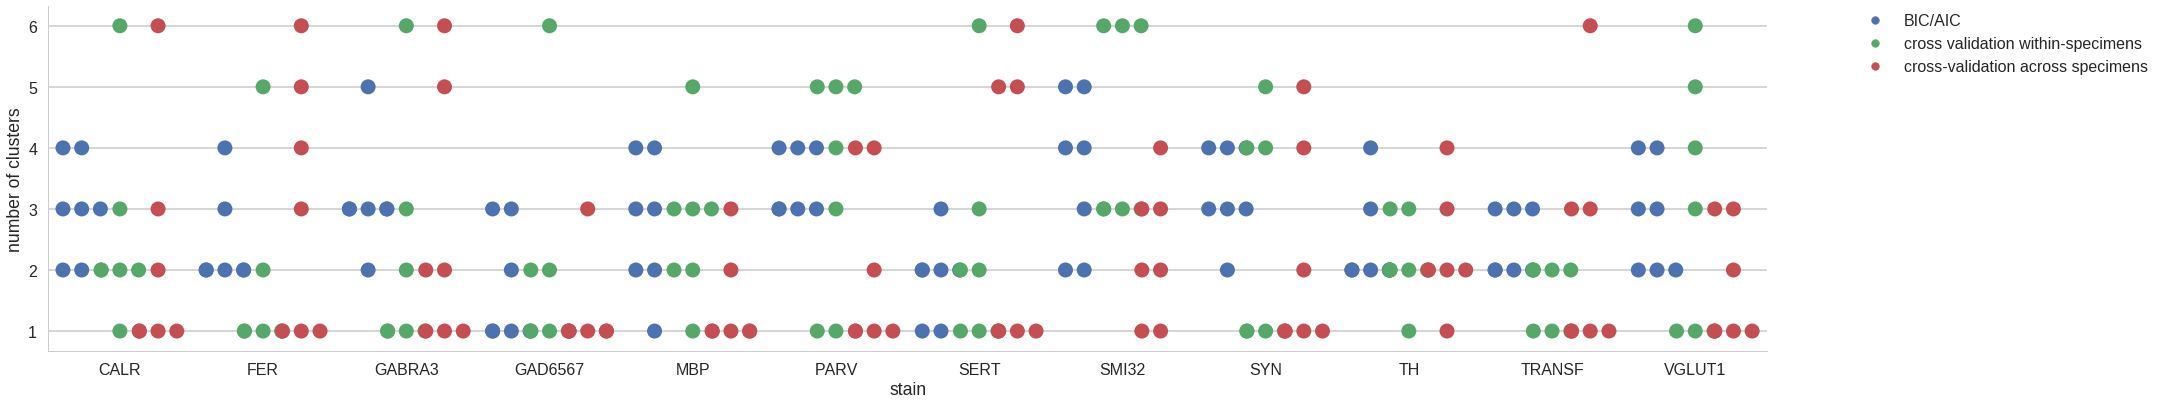

In [162]:
fac = sns.swarmplot('stain', 'number of clusters', 'variable', pandas.melt(tmp_swarm, id_vars=['subject_id', 'stain'], value_vars=['BIC/AIC', 'cross validation within-specimens', 'cross-validation across specimens'], value_name='number of clusters'), split=True, size=15)
sns.despine()
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.gcf().set_size_inches(25, 6)
plt.tight_layout()
plt.savefig('/home/gdholla1/projects/bias/reports/figures/model_comparisons.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')